# Backtesting using backtest.py library 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from backtesting import Backtest, Strategy


c:\gex\.venv\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Utilities

In [2]:
def load_data(data_file='NetGEX_AbsGEX_EPS(SPY).pickle'):
    """
    Load the pickle file, sort by index (chronologically), and return the raw DataFrame.
    
    Parameters
    ----------
    data_file : str
        Filename (or path) to the pickle file containing gamma exposure data.
        
    Returns
    -------
    df : pd.DataFrame or None
        Raw DataFrame if load is successful, otherwise None if file not found.
        
    Notes
    -----
    The DataFrame is expected to contain columns such as:
        - Spot_Open, Spot_High, Spot_Low, Spot_Close
        - close_net_gex, close_abs_gex
        - Possibly many others like open_net_gex, high_abs_gex, PCT_EPS_1mo_Close, etc.
    """
    try:
        df = pd.read_pickle(data_file)
    except FileNotFoundError:
        print(f"Error: file '{data_file}' not found.")
        return None
    
    # Ensure chronological order
    df.sort_index(inplace=True)
    return df


def prepare_backtest_data(df):
    """
    Prepare the required columns for the Backtest object:
      - 'Open', 'High', 'Low', 'Close', 'Volume', 'Net_GEX', 'Abs_GEX'

    Note
    -----
    We specifically use 'close_net_gex' and 'close_abs_gex' for Net_GEX and Abs_GEX
    based on your strategy logic. If you want to use open/high/low gamma exposures,
    modify accordingly.

    Parameters
    ----------
    df : pd.DataFrame
        The raw DataFrame loaded from pickle, expected to contain:
        [Spot_Open, Spot_High, Spot_Low, Spot_Close, close_net_gex, close_abs_gex, volume_abs_gex, etc.]

    Returns
    -------
    bt_df : pd.DataFrame or None
        Cleaned DataFrame with columns suitable for backtesting. Returns None if
        required columns are missing.
    """
    required_cols = ['Spot_Open', 'Spot_High', 'Spot_Low', 'Spot_Close',
                     'close_net_gex', 'close_abs_gex']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        print(f"Missing required columns: {missing}")
        return None
    
    # Construct the DataFrame for backtesting
    bt_df = pd.DataFrame({
        'Open': df['Spot_Open'],
        'High': df['Spot_High'],
        'Low': df['Spot_Low'],
        'Close': df['Spot_Close'],
        # Fall back to a large constant volume if 'volume_abs_gex' is missing
        'Volume': df.get('volume_abs_gex', 1e6),
        'Net_GEX': df['close_net_gex'],
        'Abs_GEX': df['close_abs_gex']
    }, index=df.index)
    
    # Drop rows with any missing essential data
    bt_df.dropna(subset=['Open', 'High', 'Low', 'Close', 
                         'Volume', 'Net_GEX', 'Abs_GEX'], inplace=True)
    return bt_df

## EDA

In [3]:
def exploratory_data_analysis(df):
    """
    Perform a basic Exploratory Data Analysis (EDA) on the given DataFrame.
    
    What this does:
      1. Print DataFrame .info() and .describe().
      2. Show the first 5 rows.
      3. Plot time-series for 'Spot_Close', 'close_net_gex', and 'close_abs_gex' if available.
      4. Plot histograms for 'close_net_gex' and 'close_abs_gex' if available.
      5. Print a correlation matrix for selected columns and display a heatmap.

    Parameters
    ----------
    df : pd.DataFrame
        The raw data DataFrame (loaded from pickle).

    Notes
    -----
    - This step helps you gauge typical price ranges, gamma exposure distributions,
      and potential correlations before deciding on strategy parameters.
    - You can customize or expand these plots for deeper EDA.
    """
    # 1) Basic info
    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- DataFrame Describe ---")
    print(df.describe())

    print("\n--- DataFrame Head (first 5 rows) ---")
    print(df.head())

    # 2) Time-series line plots
    # Each plot gets its own figure
    plt.figure()
    plt.title("Spot_Close over time")
    plt.plot(df.index, df['Spot_Close'], label='Spot_Close')
    plt.legend()
    plt.show()

    if 'close_net_gex' in df.columns:
        plt.figure()
        plt.title("close_net_gex over time")
        plt.plot(df.index, df['close_net_gex'], label='close_net_gex')
        plt.legend()
        plt.show()

    if 'close_abs_gex' in df.columns:
        plt.figure()
        plt.title("close_abs_gex over time")
        plt.plot(df.index, df['close_abs_gex'], label='close_abs_gex')
        plt.legend()
        plt.show()

    # 3) Histograms
    if 'close_net_gex' in df.columns:
        plt.figure()
        plt.title("Histogram of close_net_gex")
        plt.hist(df['close_net_gex'].dropna(), bins=50)
        plt.show()

    if 'close_abs_gex' in df.columns:
        plt.figure()
        plt.title("Histogram of close_abs_gex")
        plt.hist(df['close_abs_gex'].dropna(), bins=50)
        plt.show()

    # 4) Correlation analysis for selected columns
    columns_of_interest = [
        'Spot_Close', 'close_net_gex', 'close_abs_gex',
        'volume_abs_gex', 'PCT_EPS_1mo_Close'
    ]
    columns_of_interest = [c for c in columns_of_interest if c in df.columns]
    corr_df = df[columns_of_interest].corr()
    print("\n--- Correlation Matrix (selected columns) ---")
    print(corr_df)

    # Heatmap
    if len(columns_of_interest) > 1:
        plt.figure()
        plt.imshow(corr_df, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Correlation Coefficient')
        plt.xticks(range(len(columns_of_interest)), columns_of_interest, rotation=90)
        plt.yticks(range(len(columns_of_interest)), columns_of_interest)
        plt.title("Correlation Heatmap (Selected Columns)")
        plt.show()


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166500 entries, 2023-04-03 09:36:00-04:00 to 2024-12-20 15:59:00-05:00
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Spot_Open          166500 non-null  float64
 1   Spot_Close         166500 non-null  float64
 2   Spot_High          166500 non-null  float64
 3   Spot_Low           166500 non-null  float64
 4   PCT_EPS_1mo_Open   166500 non-null  float64
 5   PCT_EPS_1mo_Close  166500 non-null  float64
 6   PCT_EPS_1mo_High   166500 non-null  float64
 7   PCT_EPS_1mo_Low    166500 non-null  float64
 8   open_abs_gex       166500 non-null  float64
 9   high_abs_gex       166500 non-null  float64
 10  low_abs_gex        166500 non-null  float64
 11  close_abs_gex      166500 non-null  float64
 12  volume_abs_gex     166500 non-null  float64
 13  open_net_gex       166500 non-null  float64
 14  high_net_gex       166500 non-

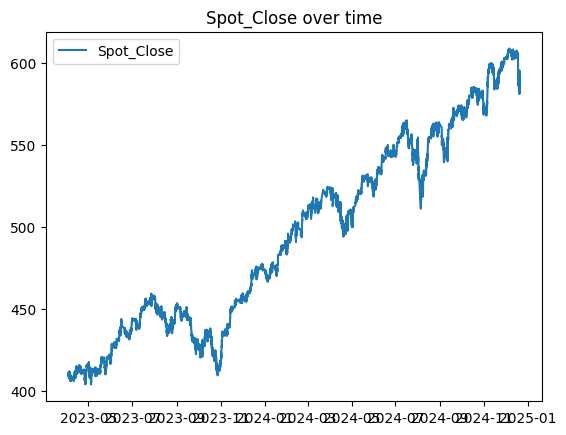

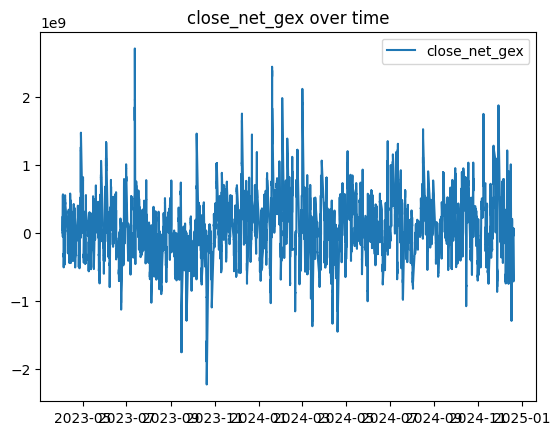

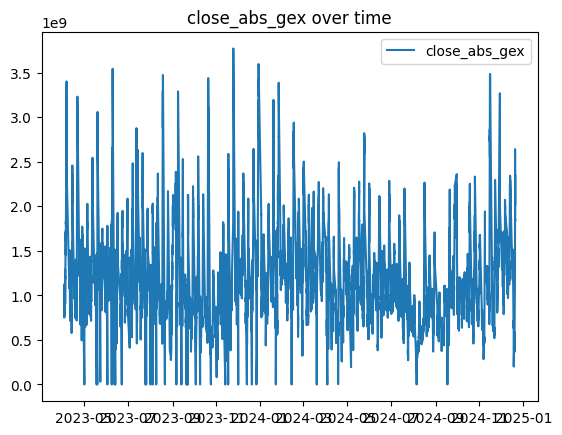

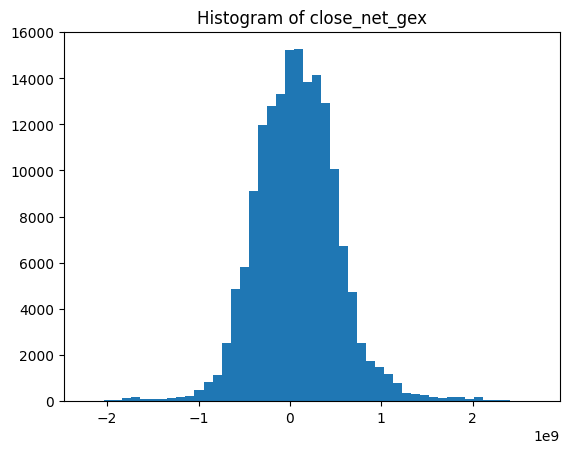

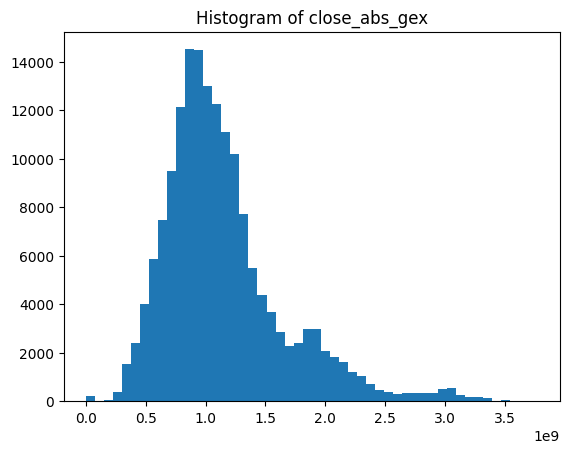


--- Correlation Matrix (selected columns) ---
                   Spot_Close  close_net_gex  close_abs_gex  volume_abs_gex  \
Spot_Close           1.000000       0.128326      -0.069219             NaN   
close_net_gex        0.128326       1.000000       0.114040             NaN   
close_abs_gex       -0.069219       0.114040       1.000000             NaN   
volume_abs_gex            NaN            NaN            NaN             NaN   
PCT_EPS_1mo_Close   -0.054803      -0.332426      -0.065657             NaN   

                   PCT_EPS_1mo_Close  
Spot_Close                 -0.054803  
close_net_gex              -0.332426  
close_abs_gex              -0.065657  
volume_abs_gex                   NaN  
PCT_EPS_1mo_Close           1.000000  


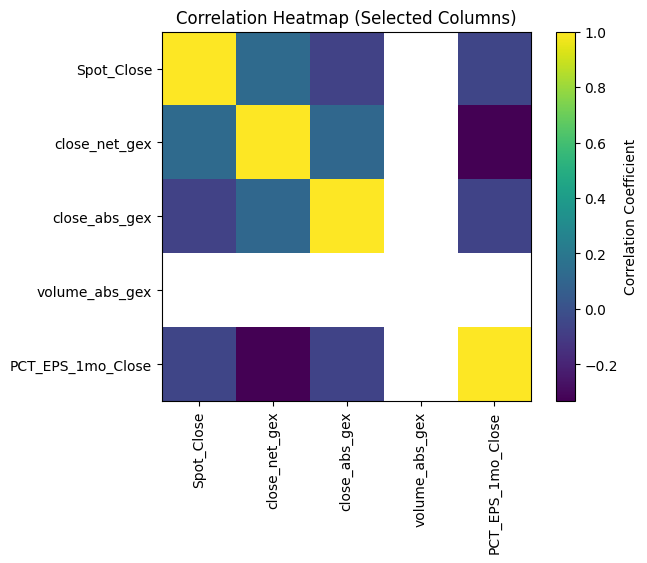

In [4]:
# --- Perform EDA ---
df_raw = load_data('NetGEX_AbsGEX_EPS(SPY).pickle')
if df_raw is not None:
    exploratory_data_analysis(df_raw)


## Strategy

In [5]:
class GammaExposureStrategy(Strategy):
    """
    A gamma-exposure-based strategy that uses price and *close-based* gamma metrics
    (Net_GEX, Abs_GEX) to decide trade entries.

    --- Strategy Logic ---
    1) Reversal Signal ("Price vs. Net GEX"):
       - If price is rising and net GEX < 0, we go short (short gamma).
       - If price is falling and net GEX > 0, we go long.

       Expectation: Price Reversal

    2) Coiled Short Signal ("Price Flat vs. Abs GEX Surge"):
       - If price movement is within a certain threshold
         (price_change_threshold),
         and abs GEX surges by some factor (abs_gex_surge_multiplier),
         then we open a short position (reduced size).

       Expectation: Low Bearish move

    Parameters
    ----------
    price_change_threshold : float
        Max fractional price change to treat as "flat".
    abs_gex_surge_multiplier : float
        Surge factor for absolute gamma exposure (indicating coiled market).
    stop_loss_percent : float
        Stop-loss percentage relative to entry price.
    take_profit_percent : float
        Take-profit percentage relative to entry price.
    risk_per_trade : float
        Fraction of account equity to risk per trade.
    minimum_position_size : float
        Minimum trade size allowed (prevents extremely small positions).
    """
    
    # Default strategy parameters (can be overridden in optimization)
    price_change_threshold = 0.001
    abs_gex_surge_multiplier = 1.2
    stop_loss_percent = 0.02
    take_profit_percent = 0.05
    risk_per_trade = 0.01
    minimum_position_size = 0.1

    def init(self):
        """
        Called once before the start of the backtest.
        """
        pass

    def detect_reversal_signal(self, price_current, price_previous, net_gex_current, net_gex_previous):
        """
        Detect a Reversal Signal based on "Price vs. Net GEX".

        - Short if price rising AND net_gex < 0.
        - Long if price falling AND net_gex > 0.

        Returns
        -------
        short_signal : bool
            True if conditions for short reversal signal are met.
        long_signal : bool
            True if conditions for long reversal signal are met.
        """
        short_signal = (price_current > price_previous) and (net_gex_current < 0)
        long_signal = (price_current < price_previous) and (net_gex_current > 0)
        return short_signal, long_signal

    def detect_coiled_short_signal(self, price_current, price_previous, abs_gex_current, abs_gex_previous):
        """
        Detect a "Coiled Short" signal based on "Price Flat vs. Abs GEX Surge".

        Conditions:
        - If fractional price change <= price_change_threshold
        - If abs_gex_current >= abs_gex_previous * abs_gex_surge_multiplier

        Returns
        -------
        bool
            True if conditions for coiled short signal are met.
        """
        denom = price_previous if price_previous != 0 else 1
        price_change = abs(price_current - price_previous) / denom

        if (price_change <= self.price_change_threshold and
            abs_gex_previous != 0 and
            abs_gex_current >= abs_gex_previous * self.abs_gex_surge_multiplier):
            return True
        return False

    def next(self):
        """
        Called for each new bar (row). Evaluates signals and places trades.
        Priority:
          1) Reversal signals (Short or Long)
          2) Coiled Short signal (reduced position)
        """
        # Need at least 2 bars to compare
        if len(self.data) < 2:
            return

        cp = self.data.Close[-1]
        pp = self.data.Close[-2]
        net_gex_c = self.data.Net_GEX[-1]
        net_gex_p = self.data.Net_GEX[-2]
        abs_gex_c = self.data.Abs_GEX[-1]
        abs_gex_p = self.data.Abs_GEX[-2]

        short_rev, long_rev = self.detect_reversal_signal(cp, pp, net_gex_c, net_gex_p)
        coiled_short = self.detect_coiled_short_signal(cp, pp, abs_gex_c, abs_gex_p)

        # Only 1 position at a time
        if self.position:
            return

        if short_rev:
            sl = cp * (1 + self.stop_loss_percent)
            tp = cp * (1 - self.take_profit_percent)
            size = self.calculate_position_size(cp, sl)
            self.sell(size=size, sl=sl, tp=tp)

        elif long_rev:
            sl = cp * (1 - self.stop_loss_percent)
            tp = cp * (1 + self.take_profit_percent)
            size = self.calculate_position_size(cp, sl)
            self.buy(size=size, sl=sl, tp=tp)

        elif coiled_short:
            sl = cp * (1 + self.stop_loss_percent)
            tp = cp * (1 - self.take_profit_percent)
            base_size = self.calculate_position_size(cp, sl)
            # For a coiled short, reduce the position by ~50%
            if base_size >= 1:
                coiled_size = int(round(base_size / 2))
                # Edge case: never place a 0-size trade
                if coiled_size < 1:
                    coiled_size = 1
            else:
                coiled_size = base_size * 0.5
            self.sell(size=coiled_size, sl=sl, tp=tp)

    def calculate_position_size(self, entry_price, stop_loss_price):
        """
        Calculate the position size (units/shares/contracts) based on:
        - risk_per_trade (fraction of equity)
        - distance between entry_price and stop_loss_price

        Returns
        -------
        int or float
            Integer size if >= 1, else float for fractional position.
        """
        account_balance = self.equity
        risk_amount = account_balance * self.risk_per_trade
        distance_to_stop = abs(stop_loss_price - entry_price)
        
        if distance_to_stop == 0:
            return 0  # Avoid division by zero

        raw_size = risk_amount / distance_to_stop
        size = max(raw_size, self.minimum_position_size)
        return int(round(size)) if size >= 1 else size

## Optimize

In [6]:
def optimize_parameters(bt):
    """
    Run a parameter optimization on GammaExposureStrategy using np.arange
    for each parameter. The final result is the best run (based on 'Equity Final [$]').

    Parameters
    ----------
    bt : backtesting.Backtest
        A Backtest instance already initialized with data and GammaExposureStrategy.

    Returns
    -------
    stats_optimized : backtesting.backtest.Strategy or pd.Series
        An object holding stats of the best run.

    Notes
    -----
    * The parameter ranges below are examples. Adjust them (start, stop, step). 
    * 'constraint' can ensure stop_loss < take_profit, etc.
    """
    stats_optimized = bt.optimize(
        # Example: [0.0005, 0.001, 0.0015, 0.002]
        price_change_threshold=list(np.arange(0.0005, 0.0021, 0.0005)),
        
        # Example: [1.0, 1.5, 2.0]
        abs_gex_surge_multiplier=list(np.arange(1.0, 2.1, 0.5)),

        # # Example: [0.01, 0.02, 0.03]
        # stop_loss_percent=list(np.arange(0.01, 0.031, 0.01)),

        # # Example: [0.03, 0.055, 0.08]
        # take_profit_percent=list(np.arange(0.03, 0.081, 0.025)),

        # # Example: [0.005, 0.01, 0.015, 0.02]
        # risk_per_trade=list(np.arange(0.005, 0.021, 0.005)),

        maximize='Equity Final [$]',
        # constraint=lambda p: p.stop_loss_percent < p.take_profit_percent
    )
    return stats_optimized


## Procedure

In [7]:
def main_procedure(df_raw, run_optimization=True):
    """
    Orchestrates the entire workflow once we have the raw data:
      1) Prepare the DataFrame for backtesting.
      2) Initialize a Backtest instance with GammaExposureStrategy.
      3) Either run parameter optimization or a single backtest (based on 'run_optimization').
      4) Print + Plot the final (best) result.

    Parameters
    ----------
    df_raw : pd.DataFrame
        The raw DataFrame containing columns like Spot_Open, Spot_Close, close_net_gex, etc.
    run_optimization : bool
        If True, runs parameter optimization. If False, runs a single backtest with default parameters.
    """
    # 1. Prepare data for backtest
    bt_df = prepare_backtest_data(df_raw)
    if bt_df is None:
        return

    # 2. Initialize the Backtest
    bt = Backtest(
        bt_df,
        GammaExposureStrategy,
        cash=100_000,
        commission=0.0005,
        trade_on_close=True
    )

    # 3. Either optimize or run a single backtest
    if run_optimization:
        print("\nRunning Parameter Optimization ...")
        stats_best = optimize_parameters(bt)
        print("\nBest Stats from Optimization:")
        print(stats_best)

        print("\nBest Parameters:")
        print(stats_best._strategy.__dict__['_params'])

        # 4. Plot the best result
        bt.plot(plot_volume=False)
    else:
        print("\nRunning Single Backtest with Default Parameters ...")
        stats = bt.run()
        print("\nSingle Backtest Stats:")
        print(stats)
        bt.plot(plot_volume=False)

In [8]:
if __name__ == "__main__":
    # Decide whether to optimize or not
    main_procedure(df_raw=df_raw, run_optimization=True)  # or False for single run


Running Parameter Optimization ...


c:\gex\.venv\Lib\site-packages\backtesting\backtesting.py:1606: RuntimeWarning: If you want to use multi-process optimization with `multiprocessing.get_start_method() == 'spawn'` (e.g. on Windows),set `backtesting.Pool = multiprocessing.Pool` (or of the desired context) and hide `bt.optimize()` call behind a `if __name__ == '__main__'` guard. Currently using thread-based paralellism, which might be slightly slower for non-numpy / non-GIL-releasing code. See https://github.com/kernc/backtesting.py/issues/1256
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/12 [00:00<?, ?it/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/166499 [00:00<?, ?bar/s]


Best Stats from Optimization:
Start                     2023-04-03 09:36...
End                       2024-12-20 15:59...
Duration                    627 days 07:23:00
Exposure Time [%]                    95.73093
Equity Final [$]                 108018.99426
Equity Peak [$]                  108453.24426
Commissions [$]                    1105.85866
Return [%]                            8.01899
Buy & Hold Return [%]                44.20591
Return (Ann.) [%]                     4.70416
Volatility (Ann.) [%]                 5.55547
CAGR [%]                              3.14723
Sharpe Ratio                          0.84676
Sortino Ratio                         1.33607
Calmar Ratio                          1.04068
Alpha [%]                             9.14214
Beta                                 -0.02541
Max. Drawdown [%]                     -4.5203
Avg. Drawdown [%]                    -0.10941
Max. Drawdown Duration      168 days 21:28:00
Avg. Drawdown Duration        1 days 12:49:00
# T

c:\gex\.venv\Lib\site-packages\backtesting\_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '2h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
c:\gex\.venv\Lib\site-packages\bokeh\util\serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))
